In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# Load the datasets
restaurants_path = 'resturants.csv'
sales_path = 'sales.csv'
items_path = 'items.csv'

restaurants_data = pd.read_csv(restaurants_path)
sales_data = pd.read_csv(sales_path)
items_data = pd.read_csv(items_path)


In [3]:
# Merge the datasets
merged_data = sales_data.merge(items_data, left_on='item_id', right_on='id', suffixes=('_sales', '_item'))
final_data = merged_data.merge(restaurants_data, left_on='store_id', right_on='id', suffixes=('_item', '_store'))
final_data = final_data[['date', 'item_id', 'price', 'item_count', 'name_item', 'kcal', 'store_id', 'name_store']]
final_data.columns = ['date', 'item_id', 'price', 'item_count', 'item_name', 'kcal', 'store_id', 'store_name']

# Ensure 'date' is in datetime format, handling errors
final_data['date'] = pd.to_datetime(final_data['date'], errors='coerce')

# Drop rows with invalid dates
final_data = final_data.dropna(subset=['date'])


# Display the merged dataset structure and sample rows
print("\nFinal Merged Dataset:")
print(f"Shape: {final_data.shape}")



Final Merged Dataset:
Shape: (109600, 8)


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam


In [5]:
final_data


,date,item_id,price,item_count,item_name,kcal,store_id,store_name
0,2019-01-01,3,29.22,2.0,Sweet Fruity Cake,931,1,Bob's Diner
1,2019-01-02,3,29.22,0.0,Sweet Fruity Cake,931,1,Bob's Diner
2,2019-01-03,3,29.22,0.0,Sweet Fruity Cake,931,1,Bob's Diner
3,2019-01-04,3,29.22,6.0,Sweet Fruity Cake,931,1,Bob's Diner
4,2019-01-05,3,29.22,4.0,Sweet Fruity Cake,931,1,Bob's Diner
...,...,...,...,...,...,...,...,...
109595,2021-12-27,86,6.50,0.0,Original Milky Cake,595,3,Sweet Shack
109596,2021-12-28,86,6.50,0.0,Original Milky Cake,595,3,Sweet Shack
109597,2021-12-29,86,6.50,0.0,Original Milky Cake,595,3,Sweet Shack
109598,2021-12-30,86,6.50,0.0,Original Milky Cake,595,3,Sweet Shack


In [6]:
final_data['date']


0        2019-01-01
1        2019-01-02
2        2019-01-03
3        2019-01-04
4        2019-01-05
            ...    
109595   2021-12-27
109596   2021-12-28
109597   2021-12-29
109598   2021-12-30
109599   2021-12-31
Name: date, Length: 109600, dtype: datetime64[ns]

In [7]:
final_data['date'].value_counts()


date
2019-01-01    100
2020-12-29    100
2021-01-04    100
2021-01-03    100
2021-01-02    100
             ... 
2020-01-07    100
2020-01-08    100
2020-01-09    100
2020-01-10    100
2021-12-31    100
Name: count, Length: 1096, dtype: int64

In [8]:
final_data[final_data['date']=='2019-01-01']


,date,item_id,price,item_count,item_name,kcal,store_id,store_name
0,2019-01-01,3,29.22,2.0,Sweet Fruity Cake,931,1,Bob's Diner
1096,2019-01-01,4,26.42,22.0,Amazing Steak Dinner with Rolls,763,1,Bob's Diner
2192,2019-01-01,12,4.87,7.0,Fantastic Sweet Cola,478,1,Bob's Diner
3288,2019-01-01,13,4.18,12.0,Sweet Frozen Soft Drink,490,1,Bob's Diner
4384,2019-01-01,16,3.21,136.0,Frozen Milky Smoothy,284,1,Bob's Diner
...,...,...,...,...,...,...,...,...
104120,2019-01-01,49,1.39,0.0,Awesome Smoothy,78,3,Sweet Shack
105216,2019-01-01,52,5.68,0.0,Original Sweet Milky Soft Drink,535,3,Sweet Shack
106312,2019-01-01,77,7.70,0.0,Blue Ribbon Frozen Milky Cake,636,3,Sweet Shack
107408,2019-01-01,81,5.11,0.0,Fantastic Milky Smoothy,383,3,Sweet Shack


In [9]:
final_data['store_name'].value_counts()


store_name
Fou Cher          30688
Bob's Diner       26304
Corner Cafe       26304
Surfs Up          10960
Sweet Shack        8768
Beachfront Bar     6576
Name: count, dtype: int64

In [10]:
final_data['sales']=final_data['price']*final_data['item_count']
final_data


,date,item_id,price,item_count,item_name,kcal,store_id,store_name,sales
0,2019-01-01,3,29.22,2.0,Sweet Fruity Cake,931,1,Bob's Diner,58.44
1,2019-01-02,3,29.22,0.0,Sweet Fruity Cake,931,1,Bob's Diner,0.00
2,2019-01-03,3,29.22,0.0,Sweet Fruity Cake,931,1,Bob's Diner,0.00
3,2019-01-04,3,29.22,6.0,Sweet Fruity Cake,931,1,Bob's Diner,175.32
4,2019-01-05,3,29.22,4.0,Sweet Fruity Cake,931,1,Bob's Diner,116.88
...,...,...,...,...,...,...,...,...,...
109595,2021-12-27,86,6.50,0.0,Original Milky Cake,595,3,Sweet Shack,0.00
109596,2021-12-28,86,6.50,0.0,Original Milky Cake,595,3,Sweet Shack,0.00
109597,2021-12-29,86,6.50,0.0,Original Milky Cake,595,3,Sweet Shack,0.00
109598,2021-12-30,86,6.50,0.0,Original Milky Cake,595,3,Sweet Shack,0.00


In [11]:
final_data[final_data['date']=='2019-01-01']


,date,item_id,price,item_count,item_name,kcal,store_id,store_name,sales
0,2019-01-01,3,29.22,2.0,Sweet Fruity Cake,931,1,Bob's Diner,58.44
1096,2019-01-01,4,26.42,22.0,Amazing Steak Dinner with Rolls,763,1,Bob's Diner,581.24
2192,2019-01-01,12,4.87,7.0,Fantastic Sweet Cola,478,1,Bob's Diner,34.09
3288,2019-01-01,13,4.18,12.0,Sweet Frozen Soft Drink,490,1,Bob's Diner,50.16
4384,2019-01-01,16,3.21,136.0,Frozen Milky Smoothy,284,1,Bob's Diner,436.56
...,...,...,...,...,...,...,...,...,...
104120,2019-01-01,49,1.39,0.0,Awesome Smoothy,78,3,Sweet Shack,0.00
105216,2019-01-01,52,5.68,0.0,Original Sweet Milky Soft Drink,535,3,Sweet Shack,0.00
106312,2019-01-01,77,7.70,0.0,Blue Ribbon Frozen Milky Cake,636,3,Sweet Shack,0.00
107408,2019-01-01,81,5.11,0.0,Fantastic Milky Smoothy,383,3,Sweet Shack,0.00


In [12]:
final_data[final_data['date']=='2019-01-01']['sales']


0          58.44
1096      581.24
2192       34.09
3288       50.16
4384      436.56
           ...  
104120      0.00
105216      0.00
106312      0.00
107408      0.00
108504      0.00
Name: sales, Length: 100, dtype: float64

In [13]:
final_data[final_data['date']=='2019-01-01']['sales'].sum()


4023.0

In [14]:
# Aggregate data by date for modeling
daily_sales = final_data.groupby('date').agg({
    'sales': 'sum'
}).reset_index()


In [15]:
daily_sales


,date,sales
0,2019-01-01,4023.00
1,2019-01-02,3074.69
2,2019-01-03,4062.71
3,2019-01-04,5006.81
4,2019-01-05,4927.53
...,...,...
1091,2021-12-27,1867.71
1092,2021-12-28,3426.50
1093,2021-12-29,3715.39
1094,2021-12-30,5266.27


In [16]:
daily_sales=daily_sales.set_index('date')
daily_sales


,sales
date,
2019-01-01,4023.00
2019-01-02,3074.69
2019-01-03,4062.71
2019-01-04,5006.81
2019-01-05,4927.53
...,...
2021-12-27,1867.71
2021-12-28,3426.50
2021-12-29,3715.39


In [17]:
from sklearn.preprocessing import MinMaxScaler
# Prepare data for LSTM
scaler = MinMaxScaler()


In [18]:
scaled_data= scaler.fit_transform(daily_sales[['sales']])
scaled_data


array([[0.24676202],
       [0.15428088],
       [0.25063462],
       ...,
       [0.21676326],
       [0.36800828],
       [0.66267509]])

In [19]:
# Set sequence length and create train/test sets
seq_length = 1


In [20]:
def create_sequences(data, seq_length):
    X=[]
    y=[]

    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])

    return np.array(X), np.array(y)


In [21]:
X, y = create_sequences(scaled_data, seq_length)


In [22]:
X


array([[[0.24676202]],

       [[0.15428088]],

       [[0.25063462]],

       ...,

       [[0.18859011]],

       [[0.21676326]],

       [[0.36800828]]])

In [23]:
len(X)


1095

In [24]:
X.shape


(1095, 1, 1)

In [25]:
len(y)


1095

In [26]:

y.shape

(1095,)

In [27]:
len(X) * 0.8


876.0

In [28]:
train_size = int(len(X) * 0.8)
train_size


876

In [29]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [30]:
len(X_train)


876

In [31]:
len(y_train)


876

In [32]:
len(X_test)


219

In [33]:
len(y_test)


219

In [34]:
X_train.shape


(876, 1, 1)

In [35]:
X_test.shape


(219, 1, 1)

In [36]:
y_train.shape


(876,)

In [37]:
y_test.shape


(219,)

In [38]:
seq_length


1

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
np.random.seed(12345)
tf.keras.utils.set_random_seed(12345)

model1 = Sequential()
model1.add(LSTM(512, input_shape=(seq_length, 1), return_sequences=True))
model1.add (Dropout (0.1))

# Second LSTM layer
model1.add(LSTM(512, return_sequences=False))
model1.add (Dropout (0.1))

# Dense layers
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='linear'))

# Compile the model
optimizer = Adam()
model1.compile(loss='mse',
              optimizer='adam')


history = model1.fit(X_train, y_train, epochs=200, batch_size=256, verbose=0)
history


C:\Users\TR\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
test_predictions1 = model1.predict(X_test)
test_predictions1


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.50417703],
       [0.60326433],
       [0.66608787],
       [0.64621866],
       [0.43940988],
       [0.5142089 ],
       [0.5180663 ],
       [0.51124936],
       [0.59745884],
       [0.66797495],
       [0.6729259 ],
       [0.46494335],
       [0.49612388],
       [0.49635485],
       [0.56281817],
       [0.6246599 ],
       [0.673382  ],
       [0.6805774 ],
       [0.4848975 ],
       [0.46001673],
       [0.51478577],
       [0.5612564 ],
       [0.6396964 ],
       [0.68868846],
       [0.68636715],
       [0.42250597],
       [0.48190504],
       [0.5234307 ],
       [0.51222974],
       [0.6204213 ],
       [0.6634129 ],
       [0.67330056],
       [0.47638014],
       [0.49502498],
       [0.5325799 ],
       [0.5570906 ],
       [0.6463797 ],
       [0.6733589 ],
       [0.6650034 ],
       [0.46980074],
       [0.54673386],
       [0.47564092],
       [0.5680988 ],
       [0.6429851 ],
       [0.6975865 ],
       [0.67864907],
       [0.48383832],
       [0.491

In [41]:
len(test_predictions1)


219

In [42]:
test_predictions1.shape


(219, 1)

In [43]:
test_predictions1 = scaler.inverse_transform(test_predictions1)[:,0]
test_predictions1


array([6662.5566, 7678.6064, 8322.805 , 8119.064 , 5998.4287, 6765.4243,
       6804.978 , 6735.0767, 7619.0767, 8342.155 , 8392.923 , 6260.2505,
       6579.979 , 6582.347 , 7263.8677, 7897.9985, 8397.6   , 8471.382 ,
       6464.8623, 6209.7324, 6771.3394, 7247.8535, 8052.1846, 8554.553 ,
       8530.75  , 5825.094 , 6434.1772, 6859.9854, 6745.1294, 7854.5356,
       8295.376 , 8396.765 , 6377.525 , 6568.7104, 6953.802 , 7205.1367,
       8120.7153, 8397.362 , 8311.685 , 6310.059 , 7098.938 , 6369.945 ,
       7318.0156, 8085.9067, 8645.794 , 8451.608 , 6454.0015, 6537.6875,
       6726.767 , 6790.219 , 7679.898 , 8356.107 , 8523.753 , 6452.8037,
       6338.52  , 6835.8013, 7128.7593, 7869.012 , 8398.027 , 8416.042 ,
       6206.657 , 6609.012 , 6322.126 , 7270.3125, 7872.942 , 8163.73  ,
       8279.9   , 6254.6895, 6170.0254, 6149.7656, 6781.9355, 7877.1836,
       8139.0195, 8289.881 , 5676.0938, 6003.504 , 6349.7383, 6596.6943,
       7375.0835, 8334.269 , 7717.0137, 6027.396 , 

In [44]:
y_test


array([0.75371388, 0.90997836, 0.85755245, 0.43995225, 0.57014323,
       0.57737839, 0.56463031, 0.74055328, 0.91512167, 0.92875916,
       0.48238313, 0.53695647, 0.53737289, 0.66575581, 0.8039397 ,
       0.93002597, 0.95025595, 0.51693714, 0.47404499, 0.57122182,
       0.66252393, 0.84099223, 0.97362808, 0.96687566, 0.4128811 ,
       0.5116729 , 0.58753532, 0.566453  , 0.79376522, 0.90273832,
       0.92979972, 0.5020309 , 0.53497775, 0.60512049, 0.65395857,
       0.85796497, 0.92996161, 0.90703612, 0.49067738, 0.63300498,
       0.50074848, 0.67676898, 0.84930403, 1.        , 0.94478886,
       0.51507057, 0.52955162, 0.56312652, 0.57467216, 0.75400157,
       0.91884897, 0.96490083, 0.5148648 , 0.49545011, 0.58305613,
       0.6388407 , 0.79714143, 0.93014202, 0.93503958, 0.47353983,
       0.54207443, 0.49269804, 0.66705968, 0.79806009, 0.86878504,
       0.89867945, 0.48146154, 0.46754319, 0.46424305, 0.57315666,
       0.79905287, 0.86255338, 0.901295  , 0.390216  , 0.44075

In [45]:
y_test.reshape(-1, 1)


array([[0.75371388],
       [0.90997836],
       [0.85755245],
       [0.43995225],
       [0.57014323],
       [0.57737839],
       [0.56463031],
       [0.74055328],
       [0.91512167],
       [0.92875916],
       [0.48238313],
       [0.53695647],
       [0.53737289],
       [0.66575581],
       [0.8039397 ],
       [0.93002597],
       [0.95025595],
       [0.51693714],
       [0.47404499],
       [0.57122182],
       [0.66252393],
       [0.84099223],
       [0.97362808],
       [0.96687566],
       [0.4128811 ],
       [0.5116729 ],
       [0.58753532],
       [0.566453  ],
       [0.79376522],
       [0.90273832],
       [0.92979972],
       [0.5020309 ],
       [0.53497775],
       [0.60512049],
       [0.65395857],
       [0.85796497],
       [0.92996161],
       [0.90703612],
       [0.49067738],
       [0.63300498],
       [0.50074848],
       [0.67676898],
       [0.84930403],
       [1.        ],
       [0.94478886],
       [0.51507057],
       [0.52955162],
       [0.563

In [46]:
y_test_inv1 = scaler.inverse_transform(y_test.reshape(-1, 1))[:,0]
y_test_inv1


array([ 9221.33, 10823.68, 10286.1 ,  6003.99,  7338.98,  7413.17,
        7282.45,  9086.38, 10876.42, 11016.26,  6439.08,  6998.68,
        7002.95,  8319.4 ,  9736.35, 11029.25, 11236.69,  6793.4 ,
        6353.58,  7350.04,  8286.26, 10116.29, 11476.35, 11407.11,
        5726.4 ,  6739.42,  7517.32,  7301.14,  9632.02, 10749.44,
       11026.93,  6640.55,  6978.39,  7697.64,  8198.43, 10290.33,
       11028.59, 10793.51,  6524.13,  7983.57,  6627.4 ,  8432.33,
       10201.52, 11746.77, 11180.63,  6774.26,  6922.75,  7267.03,
        7385.42,  9224.28, 10914.64, 11386.86,  6772.15,  6573.07,
        7471.39,  8043.41,  9666.64, 11030.44, 11080.66,  6348.4 ,
        7051.16,  6544.85,  8332.77,  9676.06, 10401.28, 10707.82,
        6429.63,  6286.91,  6253.07,  7369.88,  9686.24, 10337.38,
       10734.64,  5493.99,  6012.24,  6592.43,  7028.86,  8552.84,
       10854.89,  9309.45,  6051.17,  5490.38,  5992.92,  7409.34,
        8084.96, 10664.43,  9699.99,  5590.89,  5403.54,  6196

In [47]:
len(y_test_inv1)


219

In [48]:
test_dates=daily_sales.index[-len(y_test_inv1):]
test_dates


DatetimeIndex(['2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
               '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-05',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=219, freq=None)

In [49]:
len(test_dates)


219

In [50]:
assert len(test_dates) == len(y_test_inv1) == len(test_predictions1), "Length of variables do not match."


In [51]:
# Check MAE value
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

performance_MAE1 = mean_absolute_error(y_test_inv1, test_predictions1)
print(f'The MAE for the model is {performance_MAE1}')

# Check MAPE value
performance_MAPE1 = mean_absolute_percentage_error(y_test_inv1, test_predictions1)
print(f'The MAPE for the model is {performance_MAPE1}')


The MAE for the model is 1582.710693671518
The MAPE for the model is 0.2651627508553792


In [52]:
1-performance_MAPE1
#it is a low performance


0.7348372491446208

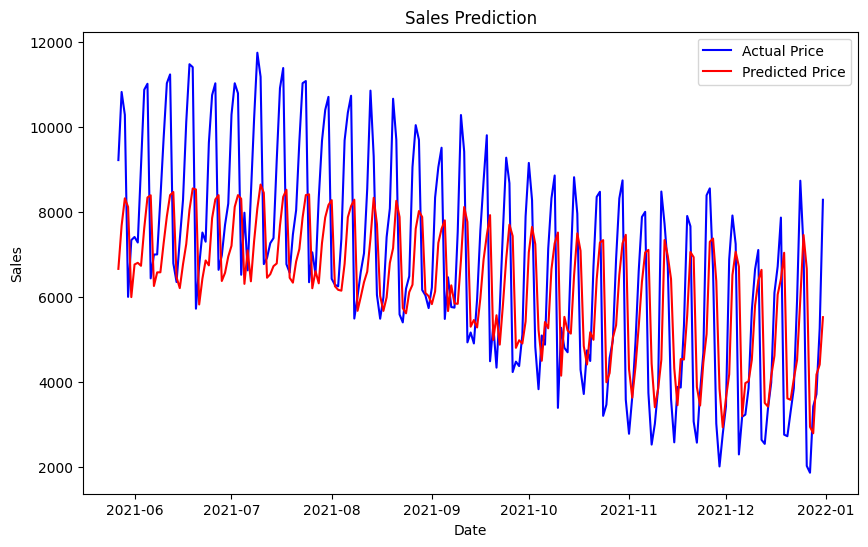

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_inv1, label='Actual Price', color='blue')
plt.plot(test_dates, test_predictions1, label='Predicted Price', color='red')
plt.title('Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [54]:
daily_sales


,sales
date,
2019-01-01,4023.00
2019-01-02,3074.69
2019-01-03,4062.71
2019-01-04,5006.81
2019-01-05,4927.53
...,...
2021-12-27,1867.71
2021-12-28,3426.50
2021-12-29,3715.39


In [55]:
!pip install ta


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [56]:
import ta


In [57]:
def calculate_indicators (df):
    df['SMA_20'] = ta.trend.sma_indicator(df['sales'], window=20)
    df['EMA_20'] = ta.trend.ema_indicator(df['sales'], window=20)
    df['RSI'] = ta.momentum.rsi(df['sales'], window=14)
    df['MACD'] = ta.trend.macd_diff(df['sales'])
    return df


In [58]:
daily_sales = calculate_indicators(daily_sales)
daily_sales


,sales,SMA_20,EMA_20,RSI,MACD
date,,,,,
2019-01-01,4023.00,NaN,NaN,NaN,NaN
2019-01-02,3074.69,NaN,NaN,NaN,NaN
2019-01-03,4062.71,NaN,NaN,NaN,NaN
2019-01-04,5006.81,NaN,NaN,NaN,NaN
2019-01-05,4927.53,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-12-27,1867.71,4745.475,4637.880237,43.570573,-178.180217
2021-12-28,3426.50,4723.693,4522.510691,47.287813,-198.783604
2021-12-29,3715.39,4625.145,4445.642053,47.971855,-182.155365


In [59]:
daily_sales = daily_sales.dropna()
daily_sales


,sales,SMA_20,EMA_20,RSI,MACD
date,,,,,
2019-02-03,2247.87,3830.3080,3834.825647,45.135366,14.490420
2019-02-04,1725.79,3799.8715,3633.965109,43.708277,-134.614358
2019-02-05,2733.73,3793.8970,3548.228432,47.180522,-157.244344
2019-02-06,3841.29,3744.9520,3576.139058,50.773711,-92.700170
2019-02-07,4539.81,3677.3720,3667.917243,52.947727,-2.793129
...,...,...,...,...,...
2021-12-27,1867.71,4745.4750,4637.880237,43.570573,-178.180217
2021-12-28,3426.50,4723.6930,4522.510691,47.287813,-198.783604
2021-12-29,3715.39,4625.1450,4445.642053,47.971855,-182.155365


In [60]:
# Prepare data for LSTM
scaler = MinMaxScaler()


In [61]:
scaled_data2= scaler.fit_transform(daily_sales[['sales' ,'SMA_20', 'EMA_20', 'RSI', 'MACD']])
scaled_data2


array([[0.07364769, 0.07385342, 0.07035694, 0.16499104, 0.4795294 ],
       [0.02273337, 0.06826887, 0.03530789, 0.08588448, 0.25162305],
       [0.12102975, 0.06717266, 0.02034732, 0.27835844, 0.21703317],
       ...,
       [0.21676326, 0.21969169, 0.17694099, 0.32222373, 0.17895672],
       [0.36800828, 0.2069918 , 0.19057861, 0.52349601, 0.36244532],
       [0.66267509, 0.21782935, 0.25313092, 0.8661489 , 0.779064  ]])

In [62]:
scaled_data2.shape


(1063, 5)

In [63]:
# Set sequence length and create train/test sets
seq_length = 1


In [64]:

def create_sequences(data, seq_length):
    X=[]
    y=[]

    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])

    return np.array(X), np.array(y)


In [65]:
X, y = create_sequences(scaled_data2, seq_length)


In [66]:
len(X)


1062

In [67]:
X.shape


(1062, 1, 5)

In [68]:
y.shape


(1062,)

In [69]:
train_size = int(len(X) * 0.8)
train_size


849

In [70]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [71]:
X_train.shape


(849, 1, 5)

In [72]:
X_test.shape


(213, 1, 5)

In [73]:
X_train.shape[2]


5

In [74]:
y_train.shape


(849,)

In [75]:
y_test.shape


(213,)

In [76]:
#I use 1 day long time series cause it has better performance than other options that I have tried.

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
np.random.seed(12345)
tf.keras.utils.set_random_seed(12345)

model2 = Sequential()
model2.add(LSTM(512, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
model2.add (Dropout (0.1))

# Second LSTM layer
model2.add(LSTM(512, return_sequences=False))
model2.add (Dropout (0.1))

# Dense layers
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='linear'))

# Compile the model
optimizer = Adam()
model2.compile(loss='mse',
              optimizer='adam')


history2 = model2.fit(X_train, y_train, epochs=200, batch_size=256, verbose=0)
history2


C:\Users\TR\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [78]:
test_predictions2 = model2.predict(X_test)
test_predictions2


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.6334408 ],
       [0.6469635 ],
       [0.85071784],
       [0.9216758 ],
       [0.5040186 ],
       [0.4803324 ],
       [0.5580617 ],
       [0.6172133 ],
       [0.7943607 ],
       [0.9074018 ],
       [0.8798868 ],
       [0.5185886 ],
       [0.5031763 ],
       [0.5517543 ],
       [0.6791657 ],
       [0.79865974],
       [0.9573982 ],
       [0.90257514],
       [0.5351935 ],
       [0.50013626],
       [0.5919759 ],
       [0.70973146],
       [0.70128316],
       [0.96425414],
       [0.9604218 ],
       [0.5752014 ],
       [0.51928484],
       [0.58676213],
       [0.6865298 ],
       [0.7528562 ],
       [0.9390238 ],
       [0.7452045 ],
       [0.54273045],
       [0.524262  ],
       [0.645308  ],
       [0.5840265 ],
       [0.81719035],
       [0.9729721 ],
       [0.94362646],
       [0.5524656 ],
       [0.5312224 ],
       [0.592996  ],
       [0.6575536 ],
       [0.7092672 ],
       [0.91909266],
       [0.99576116],
       [0.5903207 ],
       [0.530

In [79]:
len(test_predictions2)


213

In [80]:
test_predictions2.shape


(213, 1)

In [81]:
test_predictions2 = scaler.inverse_transform(np.concatenate((test_predictions2,
                                                            np.zeros((len(test_predictions2), X_train.shape[2]-1))),
                                                           axis=1))[:, 0]
test_predictions2


array([ 7988.03889659,  8126.70172125, 10216.01732241, 10943.62661712,
        6660.93213484,  6418.05170438,  7215.09509157,  7821.64081775,
        9638.12608226, 10797.25972496, 10515.11849865,  6810.33420345,
        6652.29477809,  7150.41820729,  8456.90642743,  9682.2088726 ,
       11309.92706452, 10747.76666842,  6980.60234618,  6621.12218352,
        7562.85443691,  8770.33026275,  8683.70060605, 11380.22874319,
       11340.93158145,  7390.84684348,  6817.4735301 ,  7509.39169228,
        8532.41851271,  9212.53518031, 11121.51448294,  9134.07409656,
        7057.8868865 ,  6868.5098449 ,  8109.72649153,  7481.34045216,
        9872.22338682, 11469.62342975, 11168.71068222,  7157.71216536,
        6939.88233089,  7573.31436639,  8235.29392943,  8765.569693  ,
       10917.13880457, 11703.30451297,  7545.88165196,  6934.34554807,
        7360.15220058,  8368.19994238,  9201.47506088, 10728.64126738,
       10350.31990768,  7091.55925386,  6812.04309458,  7477.87621935,
      

In [82]:
y_test


array([0.56463031, 0.74055328, 0.91512167, 0.92875916, 0.48238313,
       0.53695647, 0.53737289, 0.66575581, 0.8039397 , 0.93002597,
       0.95025595, 0.51693714, 0.47404499, 0.57122182, 0.66252393,
       0.84099223, 0.97362808, 0.96687566, 0.4128811 , 0.5116729 ,
       0.58753532, 0.566453  , 0.79376522, 0.90273832, 0.92979972,
       0.5020309 , 0.53497775, 0.60512049, 0.65395857, 0.85796497,
       0.92996161, 0.90703612, 0.49067738, 0.63300498, 0.50074848,
       0.67676898, 0.84930403, 1.        , 0.94478886, 0.51507057,
       0.52955162, 0.56312652, 0.57467216, 0.75400157, 0.91884897,
       0.96490083, 0.5148648 , 0.49545011, 0.58305613, 0.6388407 ,
       0.79714143, 0.93014202, 0.93503958, 0.47353983, 0.54207443,
       0.49269804, 0.66705968, 0.79806009, 0.86878504, 0.89867945,
       0.48146154, 0.46754319, 0.46424305, 0.57315666, 0.79905287,
       0.86255338, 0.901295  , 0.390216  , 0.44075681, 0.49733814,
       0.53989969, 0.68852136, 0.91302202, 0.76230753, 0.44455

In [83]:
y_test.reshape(-1, 1)


array([[0.56463031],
       [0.74055328],
       [0.91512167],
       [0.92875916],
       [0.48238313],
       [0.53695647],
       [0.53737289],
       [0.66575581],
       [0.8039397 ],
       [0.93002597],
       [0.95025595],
       [0.51693714],
       [0.47404499],
       [0.57122182],
       [0.66252393],
       [0.84099223],
       [0.97362808],
       [0.96687566],
       [0.4128811 ],
       [0.5116729 ],
       [0.58753532],
       [0.566453  ],
       [0.79376522],
       [0.90273832],
       [0.92979972],
       [0.5020309 ],
       [0.53497775],
       [0.60512049],
       [0.65395857],
       [0.85796497],
       [0.92996161],
       [0.90703612],
       [0.49067738],
       [0.63300498],
       [0.50074848],
       [0.67676898],
       [0.84930403],
       [1.        ],
       [0.94478886],
       [0.51507057],
       [0.52955162],
       [0.56312652],
       [0.57467216],
       [0.75400157],
       [0.91884897],
       [0.96490083],
       [0.5148648 ],
       [0.495

In [84]:
y_test_inv2 = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1),
                                                      np.zeros((len(y_test), X_train.shape[2]-1))),
                                                     axis=1))[:, 0]
y_test_inv2


array([ 7282.45,  9086.38, 10876.42, 11016.26,  6439.08,  6998.68,
        7002.95,  8319.4 ,  9736.35, 11029.25, 11236.69,  6793.4 ,
        6353.58,  7350.04,  8286.26, 10116.29, 11476.35, 11407.11,
        5726.4 ,  6739.42,  7517.32,  7301.14,  9632.02, 10749.44,
       11026.93,  6640.55,  6978.39,  7697.64,  8198.43, 10290.33,
       11028.59, 10793.51,  6524.13,  7983.57,  6627.4 ,  8432.33,
       10201.52, 11746.77, 11180.63,  6774.26,  6922.75,  7267.03,
        7385.42,  9224.28, 10914.64, 11386.86,  6772.15,  6573.07,
        7471.39,  8043.41,  9666.64, 11030.44, 11080.66,  6348.4 ,
        7051.16,  6544.85,  8332.77,  9676.06, 10401.28, 10707.82,
        6429.63,  6286.91,  6253.07,  7369.88,  9686.24, 10337.38,
       10734.64,  5493.99,  6012.24,  6592.43,  7028.86,  8552.84,
       10854.89,  9309.45,  6051.17,  5490.38,  5992.92,  7409.34,
        8084.96, 10664.43,  9699.99,  5590.89,  5403.54,  6196.64,
        6489.85,  9055.67, 10043.22,  9699.31,  6166.44,  6040

In [85]:
test_dates=daily_sales.index[-len(y_test_inv2):]
test_dates


DatetimeIndex(['2021-06-02', '2021-06-03', '2021-06-04', '2021-06-05',
               '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09',
               '2021-06-10', '2021-06-11',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=213, freq=None)

In [86]:
len(test_dates)


213

In [87]:
len(y_test_inv2)


213

In [88]:
len(test_predictions2)


213

In [89]:
#to make sure that all length are equal
assert len(test_dates) == len(y_test_inv2) == len(test_predictions2), "Length of variables do not match."


In [90]:
#Check MAE value
performance_MAE2 = mean_absolute_error(y_test_inv2, test_predictions2)
print(f'The MAE for the model is {performance_MAE2}')

#Check MAPE value
performance_MAPE2 = mean_absolute_percentage_error(y_test_inv2, test_predictions2)
print(f'The MAPE for the model is {performance_MAPE2}')


The MAE for the model is 638.4087575713278
The MAPE for the model is 0.10801709680149686


In [91]:
1 - performance_MAPE2


0.8919829031985032

In [92]:
#the sales forecast model performance improved by the help of technical indicators.
#I will use daily, weekly, yearly trends and holiday effects at part 3 for Prophet model


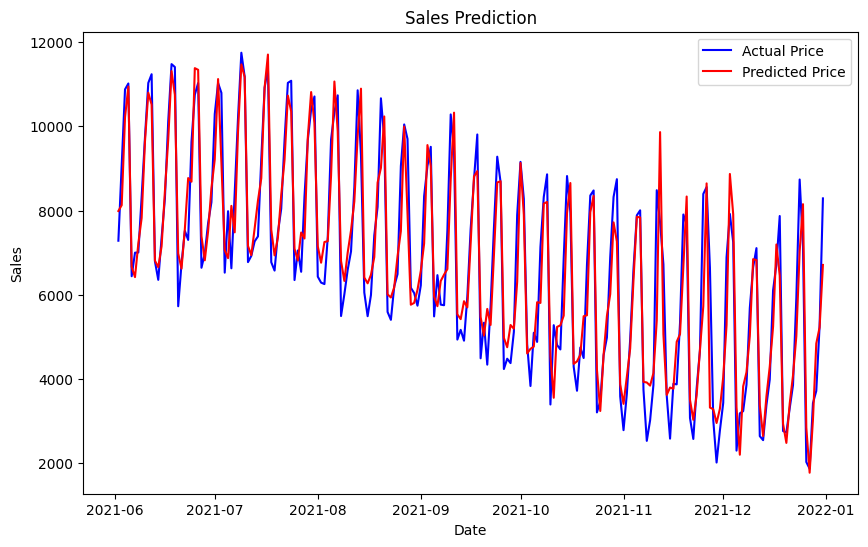

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_inv2, label='Actual Price', color='blue')
plt.plot(test_dates, test_predictions2, label='Predicted Price', color='red')
plt.title('Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [94]:
model2.save('sales_rnn_lstm.h5')


In [95]:
#future prediction


In [96]:
daily_sales


,sales,SMA_20,EMA_20,RSI,MACD
date,,,,,
2019-02-03,2247.87,3830.3080,3834.825647,45.135366,14.490420
2019-02-04,1725.79,3799.8715,3633.965109,43.708277,-134.614358
2019-02-05,2733.73,3793.8970,3548.228432,47.180522,-157.244344
2019-02-06,3841.29,3744.9520,3576.139058,50.773711,-92.700170
2019-02-07,4539.81,3677.3720,3667.917243,52.947727,-2.793129
...,...,...,...,...,...
2021-12-27,1867.71,4745.4750,4637.880237,43.570573,-178.180217
2021-12-28,3426.50,4723.6930,4522.510691,47.287813,-198.783604
2021-12-29,3715.39,4625.1450,4445.642053,47.971855,-182.155365


In [97]:
scaler = MinMaxScaler()
seq_length=1
scaled_data= scaler.fit_transform(daily_sales[['sales' ,'SMA_20', 'EMA_20', 'RSI', 'MACD']])
scaled_data


array([[0.07364769, 0.07385342, 0.07035694, 0.16499104, 0.4795294 ],
       [0.02273337, 0.06826887, 0.03530789, 0.08588448, 0.25162305],
       [0.12102975, 0.06717266, 0.02034732, 0.27835844, 0.21703317],
       ...,
       [0.21676326, 0.21969169, 0.17694099, 0.32222373, 0.17895672],
       [0.36800828, 0.2069918 , 0.19057861, 0.52349601, 0.36244532],
       [0.66267509, 0.21782935, 0.25313092, 0.8661489 , 0.779064  ]])

In [98]:
scaled_data[-1:]


array([[0.66267509, 0.21782935, 0.25313092, 0.8661489 , 0.779064  ]])

In [99]:
#we need the last data because our model is working with 1 day long time series.
last_data = scaled_data[-seq_length:].reshape(1, seq_length, 5)
last_data


array([[[0.66267509, 0.21782935, 0.25313092, 0.8661489 , 0.779064  ]]])

In [100]:
# predict the next day
prediction = model2.predict(last_data)

#Inverse transform the prediction
prediction_scaled = scaler.inverse_transform(np.concatenate((prediction,
                                                             np.zeros((prediction.shape[0], 4))),
                                                            axis=1))[:, 0]
#print the next day sales forecast?
print(f"The next day sales forecast: {prediction_scaled[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The next day sales forecast: 8466.057796141506
